In [4]:
import pandas as pd
import numpy as np
import rdkit
import rdkit.Chem.AllChem
from tqdm import tqdm
from copy import deepcopy
import random
import os
import pickle
import matplotlib.pyplot as plt

In [5]:
from IPython.core.display import Image, display
def show_atom_number_2D(mol, label = 'atomNote'):
    mol_2D = deepcopy(mol)
    rdkit.Chem.rdDepictor.Compute2DCoords(mol_2D)
    for atom in mol_2D.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol_2D

def display_mol_with_index(mol):
    return display(rdkit.Chem.Draw.MolToImage(show_atom_number_2D(mol), size=(400, 400)))

def display_mol(mol):
    mol_2D = deepcopy(mol)
    rdkit.Chem.rdDepictor.Compute2DCoords(mol_2D)
    return display(rdkit.Chem.Draw.MolToImage(mol_2D, size=(400, 400)))

/state/partition1/slurm_tmp/27683005.0.0/ipykernel_1047298/3981475789.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [6]:
def get_COOH_idx(mol):
    
    substructure = rdkit.Chem.MolFromSmarts('[CX3](=O)[OX2H1]')
    indexsall = mol.GetSubstructMatches(substructure)
    o_append=[]
    for i, num in enumerate(range(mol.GetNumAtoms())):
        if i in indexsall[0]:
            if mol.GetAtomWithIdx(i).GetSymbol() == 'C':
                C1 = i
            if mol.GetAtomWithIdx(i).GetSymbol() == 'O':
                o_append.append(i)
    for o in o_append:
        if mol.GetBondBetweenAtoms(o,C1).GetBondType() == rdkit.Chem.rdchem.BondType.SINGLE:
            O3 = o
        if mol.GetBondBetweenAtoms(o,C1).GetBondType() == rdkit.Chem.rdchem.BondType.DOUBLE:
            O2 = o
    for nei in mol.GetAtomWithIdx(C1).GetNeighbors():
        if nei.GetSymbol() =='C':
            C4 = nei.GetIdx()
    for nei in mol.GetAtomWithIdx(O3).GetNeighbors():
        if nei.GetSymbol() =='H':
            H5 = nei.GetIdx()
            
    return C1, O2, O3, C4, H5

from morfeus import BuriedVolume, Sterimol
def prop_calc_acid(m) :
    
    #get index of acid
    C1, O2, O3, C4, H5 = get_COOH_idx(m)
    
    #need xyz coords and elements
    coords = m.GetConformers()[0].GetPositions()
    elements = np.array([atom.GetSymbol() for atom in m.GetAtoms()])
    #Sterimol
    L_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).L_value
    B5_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).B_5_value
    #B1_C1_C4 = Sterimol(elements, coords, C1+1, C4+1).B_1_value
    
    return L_C1_C4, B5_C1_C4 

In [56]:
### PARAMETERS ###

prop = 'Sterimol_B5'
agg = 'min'

In [57]:
# collecting all relevant inference metrics

results_dict_seeds = {}

for SEED in [0,1,2]:
    
    directory = f'jobs_acid_benchmark_seed{SEED}/'
    results_dict = {}
    
    dirs = [
        directory + f'jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}', # active
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_xtb_1000_seed{SEED}', # active xTB
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_rdkit_1000_seed{SEED}', # active MMFF94
        
        directory + f'jobs_decoys/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_9_DFT_0',
        directory + f'jobs_decoys/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_xtb_1000_seed{SEED}_ensemble_9_xtb_0',
        directory + f'jobs_decoys/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_rdkit_1000_seed{SEED}_ensemble_9_rdkit_0',
        
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0',
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0',
    ]
    
    for d in tqdm(dirs):
        results = np.load(f'{d}/test_predictions.npy')
        targets = results[0]
        pred_targets = results[1]
        MAE = np.mean(np.abs(targets - pred_targets))
        R2 = np.corrcoef(targets, pred_targets)[0][1] ** 2
    
        results_dict[d] = (MAE, R2)
            
    results_dict_seeds[SEED] = results_dict

100%|██████████| 8/8 [00:00<00:00, 17.92it/s]


In [58]:
mae_3D_GNN_decoys_seeds = []
r2_3D_GNN_decoys_seeds = []
    
for SEED in [0,1,2]:
    results_dict = results_dict_seeds[SEED]
    directory = f'jobs_acid_benchmark_seed{SEED}/'

    dirs_3D_GNN_decoys = [
        directory + f'jobs_active/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_xtb_1000_seed{SEED}',
        directory + f'jobs_perturbed/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_rdkit_1000_seed{SEED}',
        
        directory + f'jobs_decoys/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_9_DFT_0',
        directory + f'jobs_decoys/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_xtb_1000_seed{SEED}_ensemble_9_xtb_0',
        directory + f'jobs_decoys/bond_{prop}_none_{agg}_DFT_1_2_DimeNetPlusPlus_0_dft_to_rdkit_1000_seed{SEED}_ensemble_9_rdkit_0',
        
        #directory + f'jobs_augmented/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        #directory + f'jobs_augmented/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}',
        
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_xtb_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0',
        directory + f'jobs_ensemble/bond_{prop}_{agg}_random_rdkit_10_2_DimeNetPlusPlus_0_none_1000_seed{SEED}_ensemble_0_rdkit_0',
    ]
    
    mae_3D_GNN_decoys = [results_dict[k][0].round(3) for k in dirs_3D_GNN_decoys]
    r2_3D_GNN_decoys = [results_dict[k][1].round(3) for k in dirs_3D_GNN_decoys]
    mae_3D_GNN_decoys_seeds.append(mae_3D_GNN_decoys)
    r2_3D_GNN_decoys_seeds.append(r2_3D_GNN_decoys)

In [59]:
mae_3D_GNN_decoys_seeds

[[0.202, 0.22, 0.247, 0.226, 0.271, 0.281, 0.29, 0.297],
 [0.196, 0.218, 0.241, 0.218, 0.24, 0.262, 0.262, 0.273],
 [0.215, 0.224, 0.267, 0.226, 0.278, 0.285, 0.286, 0.289]]

In [60]:
for SEED in [0,1,2]:
    print(*mae_3D_GNN_decoys_seeds[SEED][0:3]) # perturbed actives
    print(*mae_3D_GNN_decoys_seeds[SEED][3:6]) # perturbed actives with decoys
    print('NaN', *mae_3D_GNN_decoys_seeds[SEED][6:8]) # ensembles
    print()

0.202 0.22 0.247
0.226 0.271 0.281
NaN 0.29 0.297

0.196 0.218 0.241
0.218 0.24 0.262
NaN 0.262 0.273

0.215 0.224 0.267
0.226 0.278 0.285
NaN 0.286 0.289



In [61]:
mat = np.array([
    [*mae_3D_GNN_decoys_seeds[0][0:3]],
    [*mae_3D_GNN_decoys_seeds[0][3:6]],
    [np.nan, *mae_3D_GNN_decoys_seeds[0][6:8]],
])
mat += np.array([
    [*mae_3D_GNN_decoys_seeds[1][0:3]],
    [*mae_3D_GNN_decoys_seeds[1][3:6]],
    [np.nan, *mae_3D_GNN_decoys_seeds[1][6:8]],
])
mat += np.array([
    [*mae_3D_GNN_decoys_seeds[2][0:3]],
    [*mae_3D_GNN_decoys_seeds[2][3:6]],
    [np.nan, *mae_3D_GNN_decoys_seeds[2][6:8]],
])
mat /= 3

mat = (mat - mat[0,0]) / mat[0,0]
mat *= 100
mat = mat.round(0)
mat

array([[ 0.,  8., 23.],
       [ 9., 29., 35.],
       [nan, 37., 40.]])

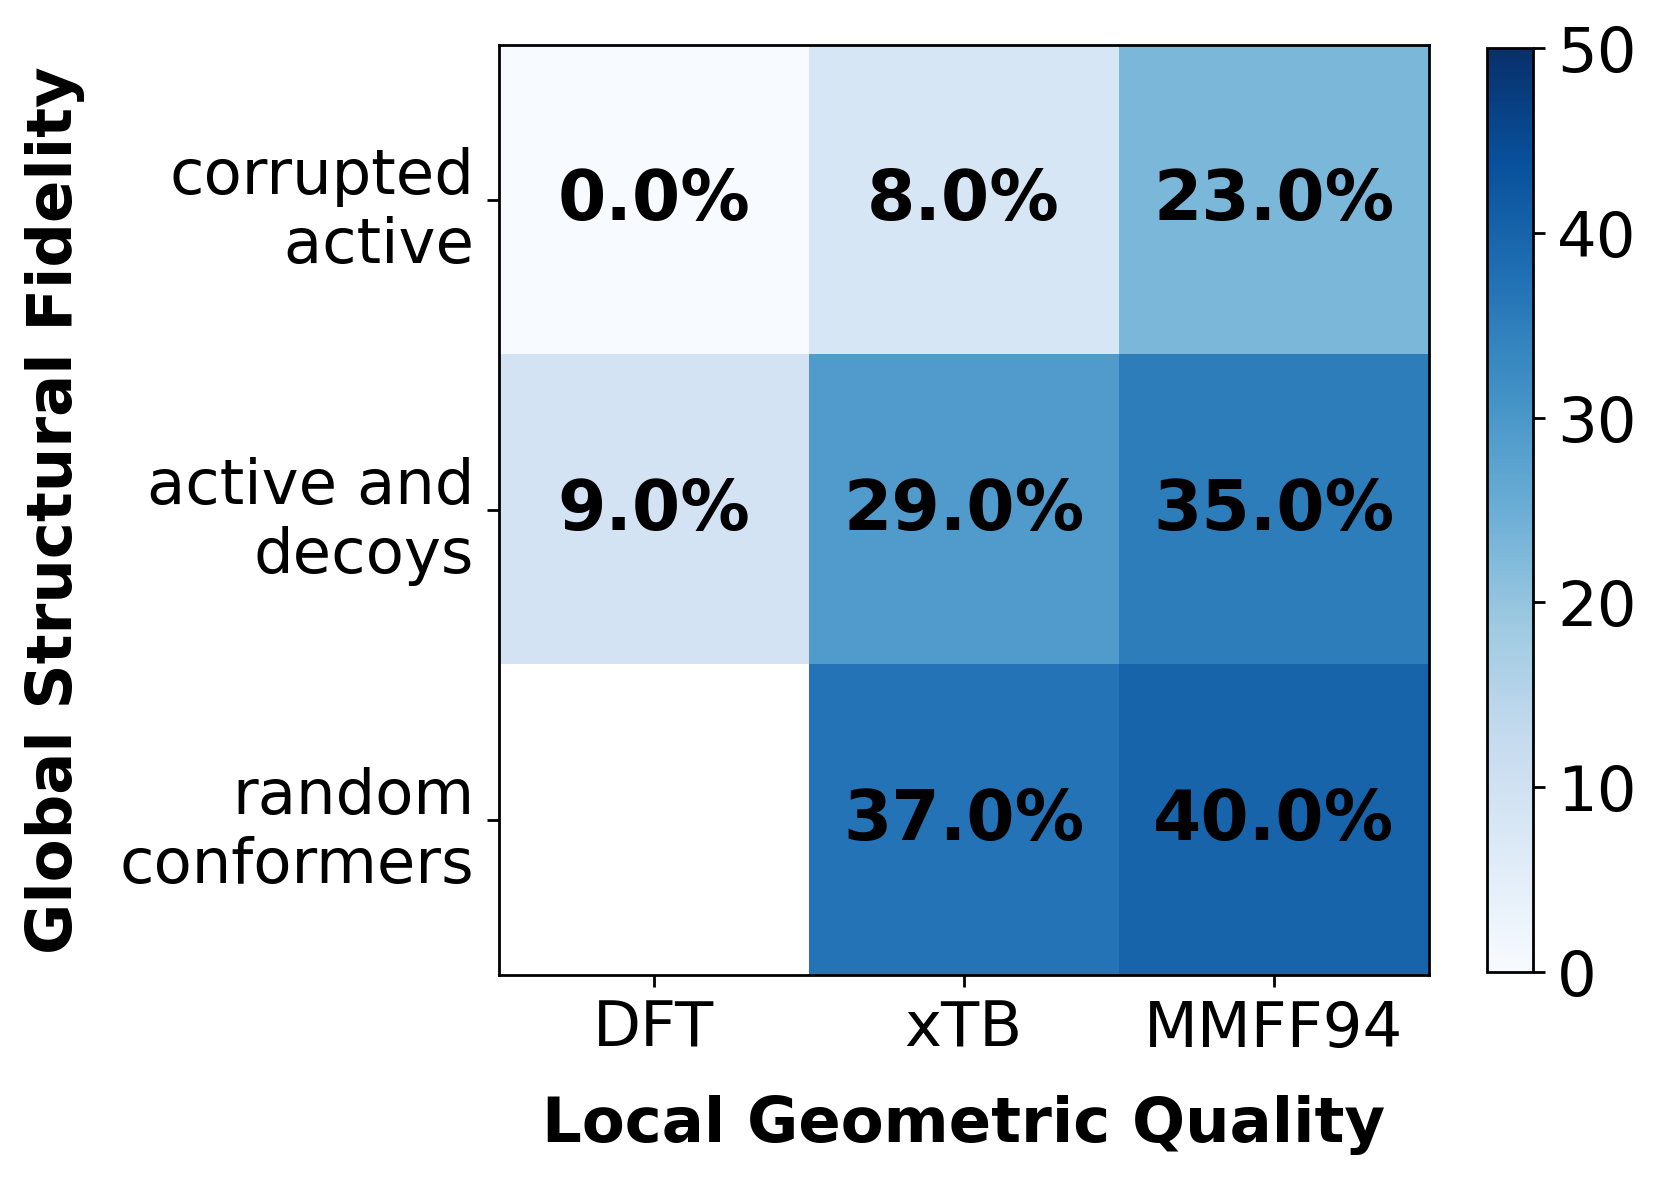

In [62]:
all_colormaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 
'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 
'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 
'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 
'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 
'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 
'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 
'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 
'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r',
'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 
'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 
'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 
'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 
'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer',
'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 
'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 
'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']


fig, ax = plt.subplots(1,1, figsize = (6,6), dpi = 250) 

# Blues, PuBu, BuGn, BuPu, Greens, OrRd, PuRd, Purples, RdPu, Reds
colormap = 'Blues'
#plt.imshow(mat, cmap = 'PuBu')
plt.imshow(mat, cmap = colormap) # BG
cbar = plt.colorbar(shrink=0.8)
cbar.ax.tick_params(labelsize=18) 

plt.text(0,0,f'{mat[0,0]}%',ha='center',va='center', fontsize =20, fontweight = 'bold')
plt.text(1,0,f'{mat[0,1]}%',ha='center',va='center', fontsize =20, fontweight = 'bold')
plt.text(2,0,f'{mat[0,2]}%',ha='center',va='center', fontsize =20, fontweight = 'bold')
plt.text(0,1,f'{mat[1,0]}%',ha='center',va='center', fontsize =20, fontweight = 'bold')
plt.text(1,1,f'{mat[1,1]}%',ha='center',va='center', fontsize =20, fontweight = 'bold')
plt.text(2,1,f'{mat[1,2]}%',ha='center',va='center', fontsize =20, fontweight = 'bold')
#plt.text(0,2,mat[2,0],ha='center',va='center', fontsize =18, fontweight = 'bold')
plt.text(1,2,f'{mat[2,1]}%',ha='center',va='center', fontsize =20, fontweight = 'bold')
plt.text(2,2,f'{mat[2,2]}%',ha='center',va='center', fontsize =20, fontweight = 'bold')

plt.xticks([0,1,2])
ax.set_xticklabels(['DFT', 'xTB', 'MMFF94'], rotation='horizontal', fontsize=18)

plt.yticks([0,1,2])
#ax.set_yticklabels(['re-optimized\n active', 'active + decoy\n ensemble', 'random\n ensemble'], rotation='horizontal', fontsize=18)
ax.set_yticklabels(['corrupted\n active', 'active and\ndecoys', 'random\nconformers'], rotation='horizontal', fontsize=18)
plt.xlabel('Local Geometric Quality', fontsize = 18, fontweight='bold',labelpad=10)
plt.ylabel('Global Structural Fidelity', fontsize = 18, fontweight='bold',labelpad=10)

plt.clim(0,50)
plt.show()